# Описание проекта

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение, чтобы привлечь новых клиентов. В нём можно будет узнать рыночную стоимость своего автомобиля. В вашем распоряжении данные о технических характеристиках, комплектации и ценах других автомобилей.

Критерии, которые важны заказчику:

- качество предсказания;
- скорость предсказания;
- время обучения.

**Признаки**
- DateCrawled — дата скачивания анкеты из базы
- VehicleType — тип автомобильного кузова
- RegistrationYear — год регистрации автомобиля
- Gearbox — тип коробки передач
- Power — мощность (л. с.)
- Model — модель автомобиля
- Kilometer — пробег (км)
- RegistrationMonth — месяц регистрации автомобиля
- FuelType — тип топлива
- Brand — марка автомобиля
- Repaired — была машина в ремонте или нет
- DateCreated — дата создания анкеты
- NumberOfPictures — количество фотографий автомобиля
- PostalCode — почтовый индекс владельца анкеты (пользователя)
- LastSeen — дата последней активности пользователя  

**Целевой признак**
- Price — цена (евро)

#  Загрузка данных

In [1]:
!pip install skimpy

In [2]:
import pandas as pd
from skimpy import clean_columns
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from math import sqrt
from time import time

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler
from sklearn.compose import ColumnTransformer

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, RandomizedSearchCV, cross_val_score
from sklearn.metrics import make_scorer, mean_squared_error
from sklearn.linear_model import LinearRegression

from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor

from phik import phik_matrix
from phik.report import plot_correlation_matrix

import warnings
warnings.filterwarnings("ignore")

Для последующего анализа создадим функцию, которая позволит визуализировать выбросы (boxplot) и распределение значений признаков (hist).

In [ ]:
def hb(data, name, description):

#зададим параметры диаграммы 'ящик с усами'

    plt.figure(figsize = (10, 1))
    h = sns.boxplot(x = data[name],
            data = data,
            linewidth=2.5,
            width=0.5)
    plt.xlabel(f'{description}', fontsize=12)
    plt.title(f'Выбросы в признаке {name}', fontsize = 12)
    h.tick_params(axis='x', labelrotation=0, labelsize=12)
    plt.show()

#    зададим параметры гистограммы

    plt.figure(figsize = (9,5))
    h = data[name].plot(
        kind = 'hist', bins = 50, label = name,
        legend = False, grid = True
        )
    plt.title(f'Распределение значений в признаке\n {name}', fontsize = 12)
    plt.xlabel(f'{description}', fontsize=12)
    plt.show()

In [5]:
help(hb)

Help on function hb in module __main__:

hb(data, name, description)
    # Для последующего анализа создадим функцию, которая позволит визуализировать выбросы (boxplot) и распределение значений признаков (hist).



Функция для заполнения пропусков на основе сгрупиированных данных по brand и model

In [ ]:
def fill_missing_values_by_brand_and_model(data, column_name):
    
    # Считаем самое частое значение для каждой группы 'brand' и 'model'
    most_frequent_values = data.groupby(['brand', 'model'])[column_name].apply(lambda x: x.mode().iloc[0] if not x.mode().empty else None)
    
    # Функция для заполнения пропуска
    def fill_value(row):
        if pd.isnull(row[column_name]):
            return most_frequent_values.get((row['brand'], row['model']), row[column_name])
        else:
            return row[column_name]

    data[column_name] = data.apply(fill_value, axis=1)
    
    return data

Функция оптимизации типов в dataframe.

In [ ]:
def optimize_memory_usage(data, print_size=True):

    # Типы, которые будем проверять на оптимизацию.
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    
    #  Размер занимаемой памяти до оптимизации (в Мб).
    before_size = data.memory_usage().sum() / 1024**2    
    for column in data.columns:
        column_type = data[column].dtypes
        if column_type in numerics:
            column_min = data[column].min()
            column_max = data[column].max()
            if str(column_type).startswith('int'):
                if column_min > np.iinfo(np.int8).min and column_max < np.iinfo(np.int8).max:
                    data[column] = data[column].astype(np.int8)
                elif column_min > np.iinfo(np.int16).min and column_max < np.iinfo(np.int16).max:
                    data[column] = data[column].astype(np.int16)
                elif column_min > np.iinfo(np.int32).min and column_max < np.iinfo(np.int32).max:
                    data[column] = data[column].astype(np.int32)
                elif column_min > np.iinfo(np.int64).min and column_max < np.iinfo(np.int64).max:
                    data[column] = data[column].astype(np.int64)  
            else:
                if column_min > np.finfo(np.float32).min and column_max < np.finfo(np.float32).max:
                    data[column] = data[column].astype(np.float32)
                else:
                    data[column] = data[column].astype(np.float64)    
    #  Размер занимаемой памяти после оптимизации (в Мб).
    after_size = data.memory_usage().sum() / 1024**2
    if print_size: print('Размер использования памяти: до {:5.2f} Mb - после {:5.2f} Mb ({:.1f}%).'.format(before_size, after_size, 100 * (before_size - after_size) / before_size))

    return data

In [8]:
def import_data_from_csv(filePath):
    #  Загрузка данных из csv-файла и оптимизация числовых типов для оптимизации использования памяти
    data = pd.read_csv(filePath, parse_dates=True, keep_date_col=True)
    #  Показать информацию о таблице до оптимизации.
    print('-' * 80)
    print(data.info())
    print('-' * 80)
    # (RU) Оптимизация типов в dataframe.
    data = optimize_memory_usage(data)
    # Show dataframe info after optimize.
    # (RU) Показать информацию о таблице после оптимизации.
    print('-' * 80)
    print(data.info())
    print('-' * 80)
    return data


In [9]:
data = import_data_from_csv('./autos.csv')

--------------------------------------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null 

In [10]:
data.sample(5)

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
283924,2016-03-30 22:39:52,850,small,1999,manual,54,seicento,150000,12,petrol,fiat,no,2016-03-30 00:00:00,0,70195,2016-04-05 13:16:02
288039,2016-03-29 23:57:32,299,sedan,1993,manual,90,golf,150000,8,petrol,volkswagen,yes,2016-03-29 00:00:00,0,86470,2016-04-01 01:17:34
214461,2016-03-19 17:50:42,4500,convertible,1994,manual,192,3er,150000,3,petrol,bmw,no,2016-03-19 00:00:00,0,89155,2016-03-19 17:50:42
46824,2016-03-07 14:58:30,2400,NaN,2005,NaN,0,NaN,100000,0,NaN,volkswagen,NaN,2016-03-07 00:00:00,0,74369,2016-04-05 11:16:31
294310,2016-04-01 17:50:45,19000,coupe,2006,manual,305,mustang,150000,6,petrol,ford,no,2016-04-01 00:00:00,0,27753,2016-04-05 13:17:06


In [11]:
data.duplicated().sum()

4

In [12]:
data.isna().sum()

DateCrawled              0
Price                    0
VehicleType          37490
RegistrationYear         0
Gearbox              19833
Power                    0
Model                19705
Kilometer                0
RegistrationMonth        0
FuelType             32895
Brand                    0
Repaired             71154
DateCreated              0
NumberOfPictures         0
PostalCode               0
LastSeen                 0
dtype: int64

In [13]:
display(data.describe(include='all'))

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
count,354369,354369.000000,316879,354369.000000,334536,354369.000000,334664,354369.000000,354369.000000,321474,354369,283215,354369,354369.0,354369.000000,354369
unique,271174,NaN,8,NaN,2,NaN,250,NaN,NaN,7,40,2,109,NaN,NaN,179150
top,2016-03-24 14:49:47,NaN,sedan,NaN,manual,NaN,golf,NaN,NaN,petrol,volkswagen,no,2016-04-03 00:00:00,NaN,NaN,2016-04-06 13:45:54
freq,7,NaN,91457,NaN,268251,NaN,29232,NaN,NaN,216352,77013,247161,13719,NaN,NaN,17
mean,NaN,4416.656776,NaN,2004.234448,NaN,110.094337,NaN,128211.172535,5.714645,NaN,NaN,NaN,NaN,0.0,50508.689087,NaN
std,NaN,4514.158514,NaN,90.227958,NaN,189.850405,NaN,37905.341530,3.726421,NaN,NaN,NaN,NaN,0.0,25783.096248,NaN
min,NaN,0.000000,NaN,1000.000000,NaN,0.000000,NaN,5000.000000,0.000000,NaN,NaN,NaN,NaN,0.0,1067.000000,NaN
25%,NaN,1050.000000,NaN,1999.000000,NaN,69.000000,NaN,125000.000000,3.000000,NaN,NaN,NaN,NaN,0.0,30165.000000,NaN
50%,NaN,2700.000000,NaN,2003.000000,NaN,105.000000,NaN,150000.000000,6.000000,NaN,NaN,NaN,NaN,0.0,49413.000000,NaN
75%,NaN,6400.000000,NaN,2008.000000,NaN,143.000000,NaN,150000.000000,9.000000,NaN,NaN,NaN,NaN,0.0,71083.000000,NaN


Вывод:

В данных присктствуют дубликаты, пропуски, а также некорректные типы данных.

# Подготовка данных

Приведем названия колонок  к стилю 'snake_case'

In [14]:
data = clean_columns(data)

data.columns

Index(['date_crawled', 'price', 'vehicle_type', 'registration_year', 'gearbox',
       'power', 'model', 'kilometer', 'registration_month', 'fuel_type',
       'brand', 'repaired', 'date_created', 'number_of_pictures',
       'postal_code', 'last_seen'],
      dtype='object')

Приведем столбцы с датой к формату datetime

In [15]:
data['date_crawled'] = pd.to_datetime(data['date_crawled'], format='%Y-%m-%d %H:%M:%S')
data['date_created'] = pd.to_datetime(data['date_created'], format='%Y-%m-%d %H:%M:%S')
data['last_seen'] = pd.to_datetime(data['last_seen'], format='%Y-%m-%d %H:%M:%S')

Удалим дубликаты

In [16]:
data = data.drop_duplicates()
data.duplicated().sum()

0

**Price**

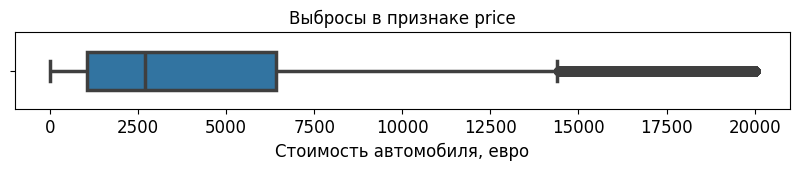

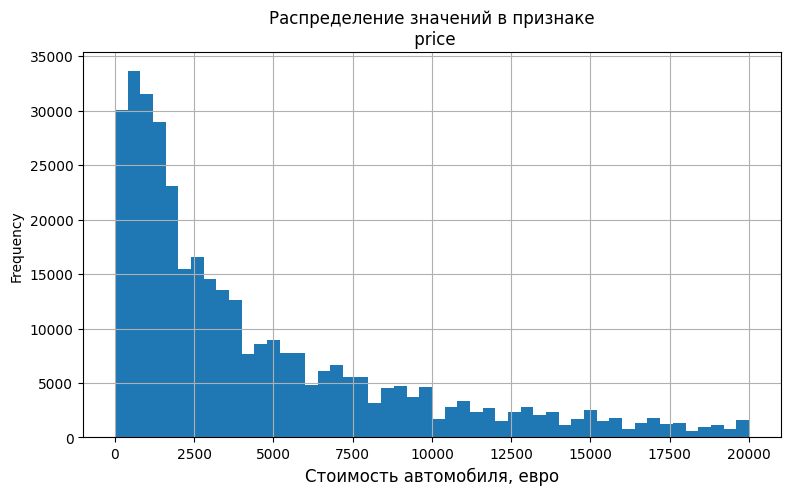

In [17]:
hb(data, 'price', 'Стоимость автомобиля, евро')

In [18]:
data.price.describe()

count    354365.000000
mean       4416.679830
std        4514.176349
min           0.000000
25%        1050.000000
50%        2700.000000
75%        6400.000000
max       20000.000000
Name: price, dtype: float64

Присутствует большое количество объявлений со стоимостью автомобиля, близкой к нулю. Вероятно, разместившие объявление владельцы предполагали назвать цену непосредственно в процессе общения с потенциальными покупателями, 'по договоренности'. Поскольку нас интересует точная цифра реальной стоимости, удалим данные для которых цена автомобился составляет менее 100 евро.

In [19]:
data = data.query('price > 100')

In [20]:
data.price.describe()

count    340020.000000
mean       4602.498115
std        4514.920302
min         101.000000
25%        1200.000000
50%        2900.000000
75%        6500.000000
max       20000.000000
Name: price, dtype: float64

**Vehicle Type**

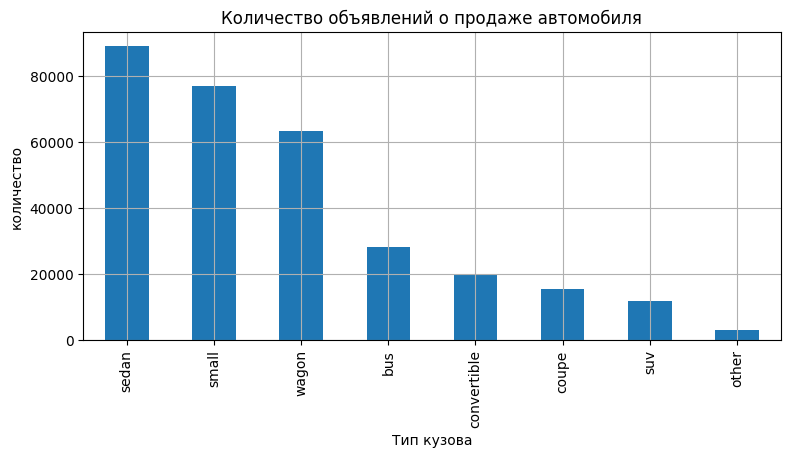

In [21]:
data.pivot_table(
    index='vehicle_type', 
     values='registration_year',
    aggfunc='count',
).sort_values(by='registration_year', ascending=False).plot(
    kind='bar', 
    title='Количество объявлений о продаже автомобиля',
    xlabel='Тип кузова', 
    figsize=(9, 4), 
    ylabel='количество', 
    linewidth=10,
    grid=True,
    legend=False
);

In [22]:
f"Пропуски составляют: {(data['vehicle_type'].isna().sum()/len(data)*100).round(2)}%"


'Пропуски составляют: 9.49%'

Заменим пропуски средним на основе данных из model и brand.

In [24]:
data['vehicle_type'].value_counts()

vehicle_type
sedan          88965
small          77028
wagon          63383
bus            28256
convertible    19807
coupe          15532
suv            11758
other           3040
Name: count, dtype: int64

In [25]:
data = fill_missing_values_by_brand_and_model(data, 'vehicle_type')

In [26]:
data['vehicle_type'].value_counts()


vehicle_type
sedan          100125
small           85134
wagon           66467
bus             31660
convertible     20028
coupe           16034
suv             12326
other            3062
Name: count, dtype: int64

In [27]:
data['vehicle_type'].isna().sum()

5184

Оставшиеся пропуски заменим на `'unknown'`, так как видимо нет информации о похожих автомобилях.

In [28]:
data['vehicle_type'] = data['vehicle_type'].fillna('unknown')

In [29]:
data['vehicle_type'].value_counts()

vehicle_type
sedan          100125
small           85134
wagon           66467
bus             31660
convertible     20028
coupe           16034
suv             12326
unknown          5184
other            3062
Name: count, dtype: int64

**Registration Year**

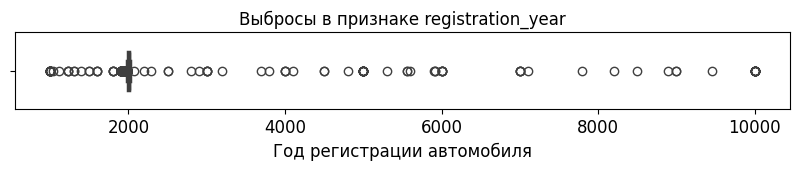

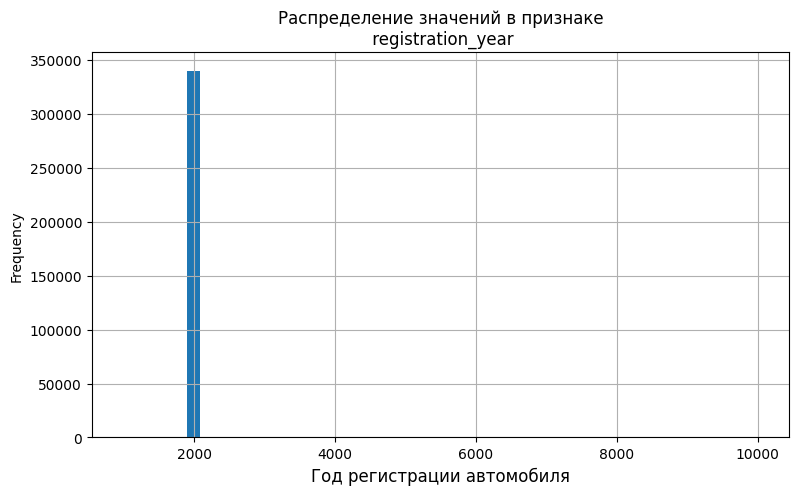

In [30]:
hb(data, 'registration_year', 'Год регистрации автомобиля')

In [31]:
data.sort_values(by = 'registration_year', ascending = False)['registration_year'].unique()


array([9999, 9450, 9000, 8888, 8500, 8200, 7800, 7100, 7000, 6000, 5911,
       5900, 5600, 5555, 5300, 5000, 4800, 4500, 4100, 4000, 3800, 3700,
       3200, 3000, 2900, 2800, 2500, 2290, 2200, 2066, 2019, 2018, 2017,
       2016, 2015, 2014, 2013, 2012, 2011, 2010, 2009, 2008, 2007, 2006,
       2005, 2004, 2003, 2002, 2001, 2000, 1999, 1998, 1997, 1996, 1995,
       1994, 1993, 1992, 1991, 1990, 1989, 1988, 1987, 1986, 1985, 1984,
       1983, 1982, 1981, 1980, 1979, 1978, 1977, 1976, 1975, 1974, 1973,
       1972, 1971, 1970, 1969, 1968, 1967, 1966, 1965, 1964, 1963, 1962,
       1961, 1960, 1959, 1958, 1957, 1956, 1955, 1954, 1953, 1952, 1951,
       1950, 1949, 1948, 1947, 1946, 1945, 1944, 1943, 1942, 1941, 1940,
       1938, 1937, 1936, 1935, 1934, 1933, 1932, 1931, 1930, 1929, 1928,
       1927, 1925, 1923, 1910, 1800, 1602, 1600, 1500, 1400, 1300, 1234,
       1111, 1039, 1001, 1000], dtype=int16)

Посмотрим на последнюю дату скачивания анкет

In [32]:
data['date_crawled'].max()

Timestamp('2016-04-07 14:36:58')

Отсортируем данные о регистрации по этой дате, а так же удалим совсем старые.

In [33]:
data = data.query('registration_year > 1900 and registration_year < 2017')

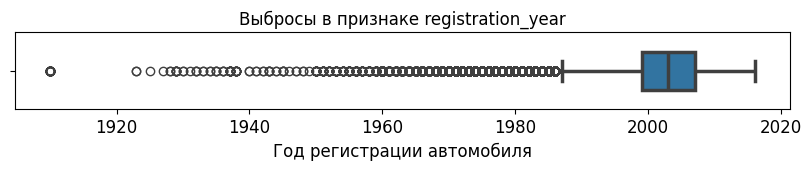

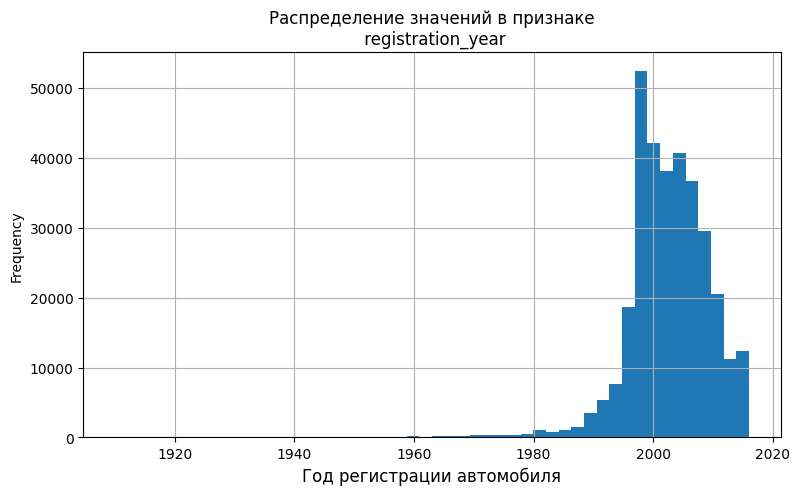

In [34]:
hb(data, 'registration_year', 'Год регистрации автомобиля')

**Gearbox**

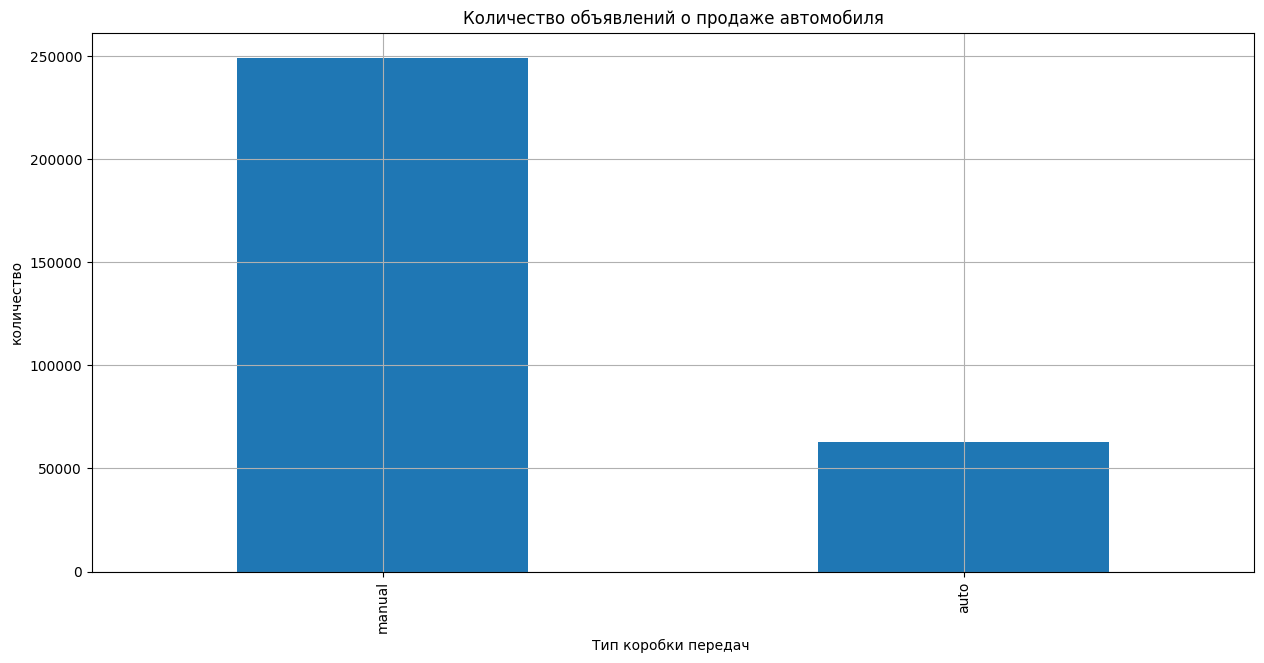

In [35]:
data.pivot_table(
    index='gearbox', 
     values='registration_year',
    aggfunc='count',
).sort_values(by='registration_year', ascending=False).plot(
    kind='bar', 
    title='Количество объявлений о продаже автомобиля',
    xlabel='Тип коробки передач ', 
    figsize=(15, 7), 
    ylabel='количество', 
    linewidth=12,
    grid=True,
    legend=False
);

In [36]:
data['gearbox'].unique()

array(['manual', 'auto', nan], dtype=object)

In [37]:
f"Пропуски составляют: {(data['gearbox'].isna().sum()/len(data)*100).round(2)}%"

'Пропуски составляют: 4.41%'

Заменим пропуски средним на основе данных из model и brand.

In [39]:
data['gearbox'].value_counts()

gearbox
manual    249168
auto       62763
Name: count, dtype: int64

In [40]:
data['gearbox'].isna().sum()

14376

In [41]:
data = fill_missing_values_by_brand_and_model(data, 'gearbox')

In [42]:
data['gearbox'].value_counts()

gearbox
manual    259580
auto       64384
Name: count, dtype: int64

In [43]:
data['gearbox'].isna().sum()

2343

Оставшиеся пропуски заменим на `'unknown'`, так как видимо нет информации о похожих автомобилях.

In [44]:
data['gearbox'] = data['gearbox'].fillna('unknown')

In [45]:
data['gearbox'].value_counts()

gearbox
manual     259580
auto        64384
unknown      2343
Name: count, dtype: int64

**Power**

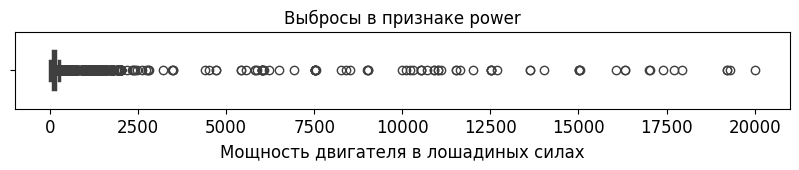

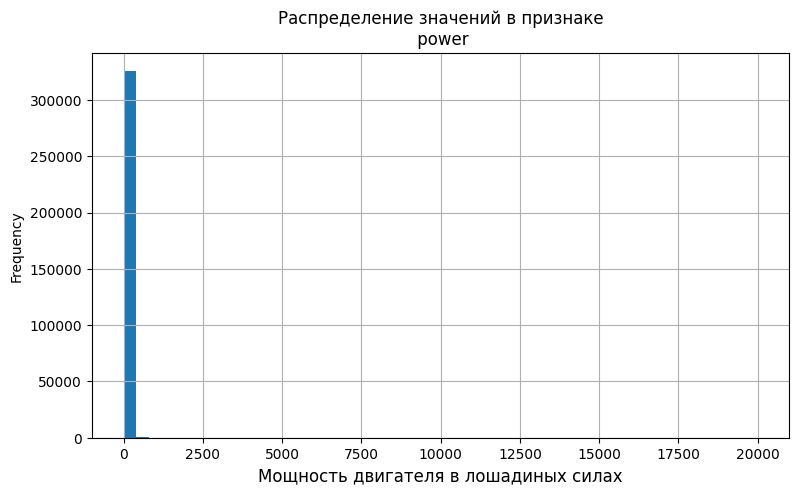

In [46]:
hb(data, 'power', 'Мощность двигателя в лошадиных силах')

Удалим данные о мощности дигателя свыше 2500 л.с., так как даже кастомные авто в большенстве своем не превышают этой отметки. минимальную мощностью оставим 1л.с., так как по сей день делают и продаются копии авто  Benz Patent Motorwagen.

In [47]:
data = data.query('power >= 1 and power < 2500')

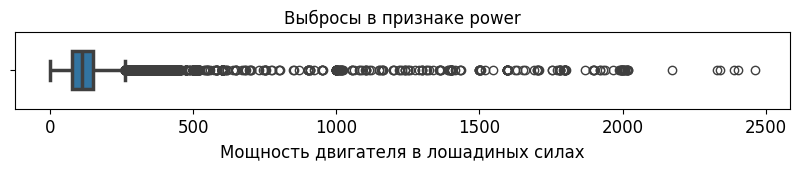

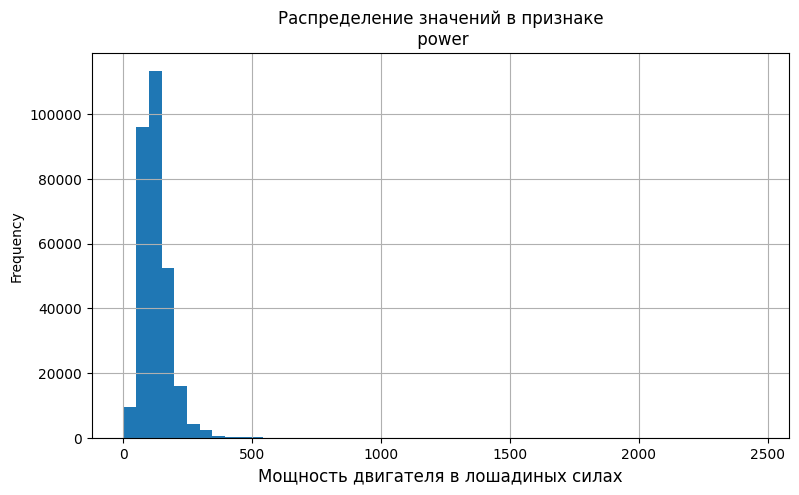

In [48]:
hb(data, 'power', 'Мощность двигателя в лошадиных силах')

**Model**

In [49]:
data['model'].unique()

array([nan, 'grand', 'golf', 'fabia', '3er', '2_reihe', 'c_max',
       '3_reihe', 'passat', 'navara', 'polo', 'twingo', 'a_klasse',
       'scirocco', '5er', 'arosa', 'other', 'civic', 'transporter',
       'punto', 'e_klasse', 'clio', 'kadett', 'one', 'fortwo', '1er',
       'b_klasse', 'a8', 'jetta', 'fiesta', 'c_klasse', 'micra', 'vito',
       'sprinter', 'astra', '156', 'escort', 'forester', 'xc_reihe',
       'scenic', 'ka', 'a1', 'focus', 'a4', 'tt', 'a6', 'jazz', 'omega',
       'slk', '7er', 'combo', 'corsa', '80', '147', 'z_reihe', 'sorento',
       'ibiza', 'mustang', 'eos', 'touran', 'getz', 'insignia', 'almera',
       'megane', 'a3', 'lupo', 'r19', 'caddy', 'mondeo', 'cordoba',
       'colt', 'impreza', 'vectra', 'berlingo', 'tiguan', '6_reihe', 'c4',
       'panda', 'up', 'i_reihe', 'ceed', 'kangoo', '5_reihe', 'yeti',
       'octavia', 'zafira', 'mii', 'rx_reihe', '6er', 'modus', 'fox',
       'matiz', 'beetle', 'rio', 'touareg', 'logan', 'spider', 'cuore',
       's_m

In [50]:
f"Пропуски составляют: {(data['model'].isna().sum()/len(data)*100).round(2)}%"

'Пропуски составляют: 3.74%'

Модель - это основопологающий фактор, который на прямую воздействует на образование цены и заменить его на что-либо другое будет неправильно, удалим отсутствующие значения из наших данных.

In [51]:

data.dropna(subset=['model'], inplace=True)

In [52]:
data['model'].isna().sum()

0

**Kilometer**

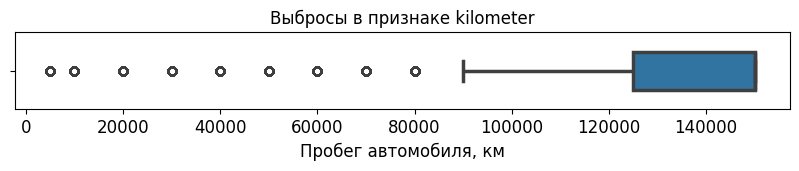

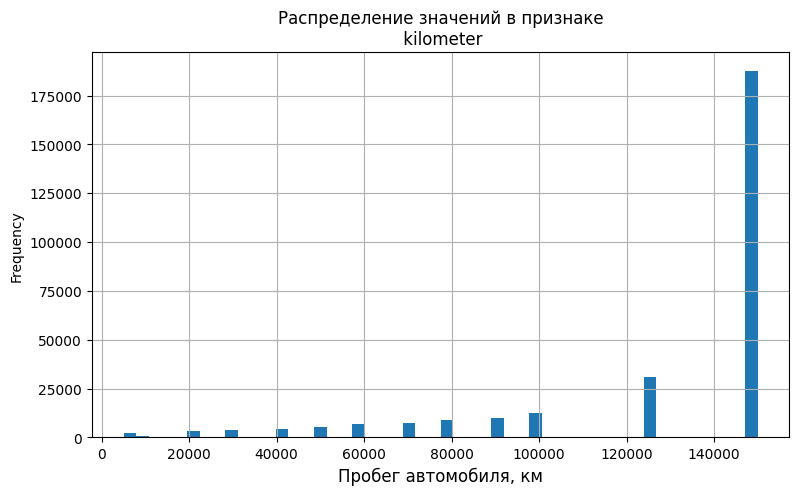

In [53]:
hb(data, 'kilometer', 'Пробег автомобиля, км')

**Registration Month**

In [54]:
data['registration_month'].unique()

array([ 8,  6,  7, 10,  0, 12, 11,  2,  3,  1,  4,  5,  9], dtype=int8)

Данный параметр не влияет на ценообразование. Чтобы не терять данные заменим пропуски средним месяцем.

In [55]:
data.loc[data['registration_month'] == 0,'registration_month'] =6

In [56]:
data['registration_month'].unique()

array([ 8,  6,  7, 10, 12, 11,  2,  3,  1,  4,  5,  9], dtype=int8)

**Fuel Type**

In [57]:
data['fuel_type'].value_counts()

fuel_type
petrol      180330
gasoline     85818
lpg           4411
cng            466
hybrid         179
other           72
electric        58
Name: count, dtype: int64

Поскольку petrol и gasoline – это разное обозначение одного и того же типа топлива, заменим название gasoline на наиболее часто встречаемое petrol


In [58]:
data.loc[data['fuel_type'] == 'gasoline','fuel_type'] = 'petrol'

In [59]:
data['fuel_type'].value_counts()

fuel_type
petrol      266148
lpg           4411
cng            466
hybrid         179
other           72
electric        58
Name: count, dtype: int64

Заменим пропуски средним на основе данных из model и brand.


In [61]:
data['fuel_type'].isna().sum()

12632

In [62]:
data['fuel_type'].value_counts()

fuel_type
petrol      266148
lpg           4411
cng            466
hybrid         179
other           72
electric        58
Name: count, dtype: int64

In [63]:
data = fill_missing_values_by_brand_and_model(data, 'fuel_type')

In [64]:
data['fuel_type'].value_counts()

fuel_type
petrol      278780
lpg           4411
cng            466
hybrid         179
other           72
electric        58
Name: count, dtype: int64

In [65]:
data['fuel_type'].isna().sum()

0

**Brand**

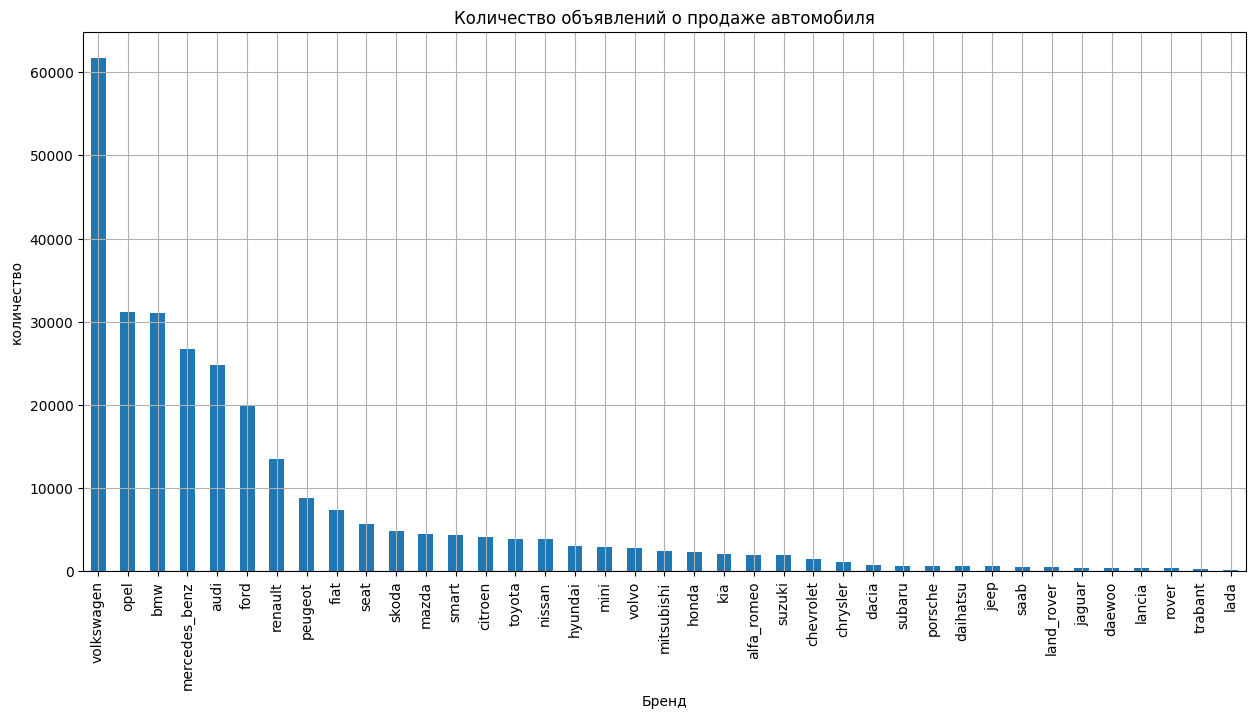

In [66]:
data.pivot_table(
    index='brand', 
     values='registration_year',
    aggfunc='count',
).sort_values(by='registration_year', ascending=False).plot(
    kind='bar', 
    title='Количество объявлений о продаже автомобиля',
    xlabel='Бренд', 
    figsize=(15, 7), 
    ylabel='количество', 
    linewidth=12,
    grid=True,
    legend=False
);

**Repaired**

In [67]:
data['repaired'].value_counts(ascending = False, dropna = False)

repaired
no     218407
NaN     38691
yes     26868
Name: count, dtype: int64

In [68]:
f"Пропуски составляют: {((data['repaired'].isna().sum()/len(data))*100).round(2)} %"

'Пропуски составляют: 13.63 %'

Терять 13% информации не хочется, заменим пропуски на 'unknown'.

In [69]:
data['repaired']=data['repaired'].fillna('unknown')

In [70]:
data['repaired'].value_counts(ascending = False, dropna = False)

repaired
no         218407
unknown     38691
yes         26868
Name: count, dtype: int64

**Date Created**

In [71]:
data['date_created'].describe()

count                           283966
mean     2016-03-20 19:26:30.553798400
min                2015-03-20 00:00:00
25%                2016-03-13 00:00:00
50%                2016-03-21 00:00:00
75%                2016-03-29 00:00:00
max                2016-04-07 00:00:00
Name: date_created, dtype: object

**Number of Pictures**

In [72]:
data['number_of_pictures'].describe()

count    283966.0
mean          0.0
std           0.0
min           0.0
25%           0.0
50%           0.0
75%           0.0
max           0.0
Name: number_of_pictures, dtype: float64

Данный столбец не несет никакой информации. Удалим его.

In [73]:
data = data.drop(['number_of_pictures'], axis=1)

In [74]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 283966 entries, 2 to 354368
Data columns (total 15 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   date_crawled        283966 non-null  datetime64[ns]
 1   price               283966 non-null  int16         
 2   vehicle_type        283966 non-null  object        
 3   registration_year   283966 non-null  int16         
 4   gearbox             283966 non-null  object        
 5   power               283966 non-null  int16         
 6   model               283966 non-null  object        
 7   kilometer           283966 non-null  int32         
 8   registration_month  283966 non-null  int8          
 9   fuel_type           283966 non-null  object        
 10  brand               283966 non-null  object        
 11  repaired            283966 non-null  object        
 12  date_created        283966 non-null  datetime64[ns]
 13  postal_code         283966 non-nul

**Postal Code**

In [75]:
data['postal_code'].value_counts()

postal_code
10115    794
65428    488
60311    260
66333    259
52525    245
        ... 
31097      1
82444      1
94359      1
72361      1
95691      1
Name: count, Length: 8107, dtype: int64

**Last Seen**

In [76]:
data['last_seen'].describe()

count                           283966
mean     2016-03-30 05:52:37.358891520
min                2016-03-05 14:15:08
25%         2016-03-23 14:46:57.500000
50%         2016-04-04 04:48:55.500000
75%                2016-04-06 10:47:02
max                2016-04-07 14:58:51
Name: last_seen, dtype: object

In [77]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 283966 entries, 2 to 354368
Data columns (total 15 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   date_crawled        283966 non-null  datetime64[ns]
 1   price               283966 non-null  int16         
 2   vehicle_type        283966 non-null  object        
 3   registration_year   283966 non-null  int16         
 4   gearbox             283966 non-null  object        
 5   power               283966 non-null  int16         
 6   model               283966 non-null  object        
 7   kilometer           283966 non-null  int32         
 8   registration_month  283966 non-null  int8          
 9   fuel_type           283966 non-null  object        
 10  brand               283966 non-null  object        
 11  repaired            283966 non-null  object        
 12  date_created        283966 non-null  datetime64[ns]
 13  postal_code         283966 non-nul

In [78]:
data.duplicated().sum()

0

# Проверка на мультиколлинеарность

interval columns not set, guessing: ['price', 'registration_year', 'power', 'kilometer', 'registration_month', 'postal_code']


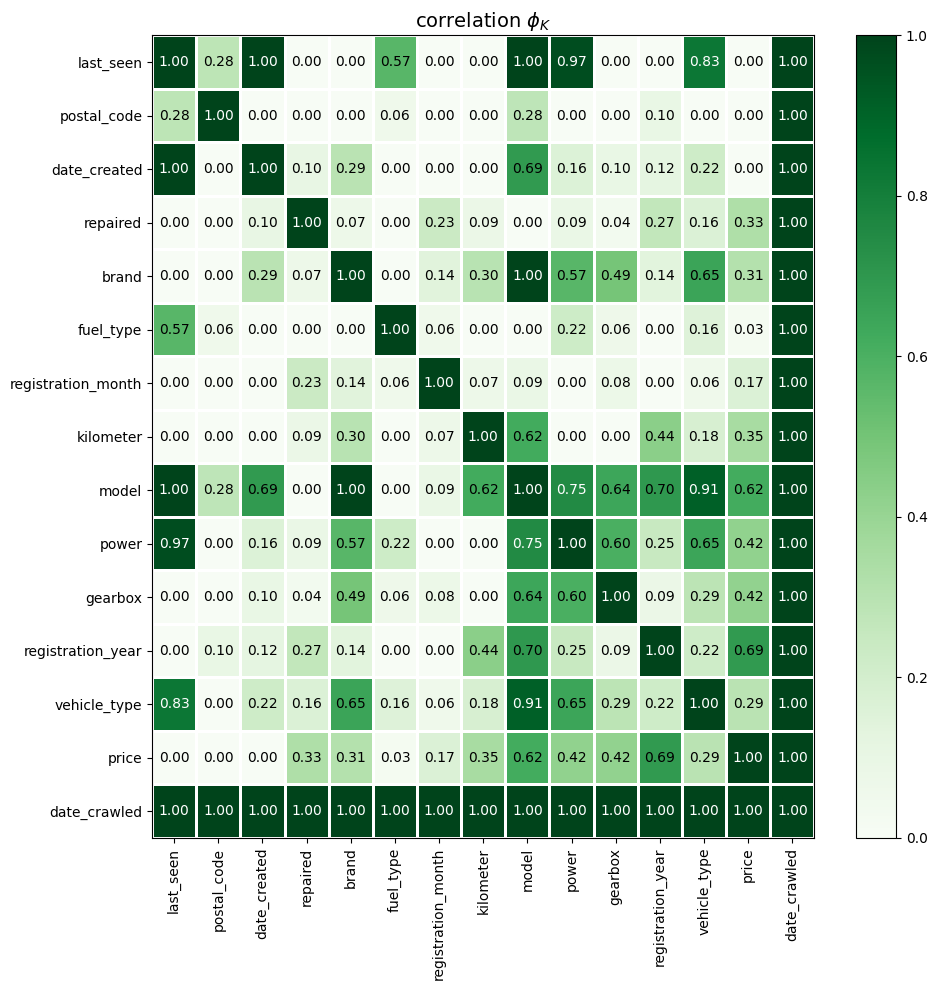

In [79]:
phik_overview = data.sample(1000).phik_matrix()
plot_correlation_matrix(phik_overview.values, x_labels=phik_overview.columns, y_labels=phik_overview.index, 
                        vmin=0, vmax=1, color_map='Greens', title=r'correlation $\phi_K$', fontsize_factor=1,
                        figsize=(10,10))
plt.tight_layout()

**Вывод:**\
Aнализ матрицы показал, что признаки `last_seen` и `date_crawled` имеют сильную коррелицию с другими признаками, при обучении их использовать не будем.\
У признаков `fuel_type`, `date_created`, `postal_code` не наблюдается корреляции с целевым признаком.\
У признака `registration_month` наблюдается незначительная корреляция с целевым признаком, в отличии от `registration_year`, оставим один наиболее значимый признак.

In [80]:
data.columns

Index(['date_crawled', 'price', 'vehicle_type', 'registration_year', 'gearbox',
       'power', 'model', 'kilometer', 'registration_month', 'fuel_type',
       'brand', 'repaired', 'date_created', 'postal_code', 'last_seen'],
      dtype='object')

In [81]:
columns = ['price', 'vehicle_type', 'registration_year', 'gearbox', 'power', 'model', 'kilometer', 'brand', 'repaired']

In [82]:
df = data[columns].copy()
df.head(5)

,price,vehicle_type,registration_year,gearbox,power,model,kilometer,brand,repaired
2,9800,suv,2004,auto,163,grand,125000,jeep,unknown
3,1500,small,2001,manual,75,golf,150000,volkswagen,no
4,3600,small,2008,manual,69,fabia,90000,skoda,no
5,650,sedan,1995,manual,102,3er,150000,bmw,yes
6,2200,convertible,2004,manual,109,2_reihe,150000,peugeot,no


In [83]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 283966 entries, 2 to 354368
Data columns (total 9 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   price              283966 non-null  int16 
 1   vehicle_type       283966 non-null  object
 2   registration_year  283966 non-null  int16 
 3   gearbox            283966 non-null  object
 4   power              283966 non-null  int16 
 5   model              283966 non-null  object
 6   kilometer          283966 non-null  int32 
 7   brand              283966 non-null  object
 8   repaired           283966 non-null  object
dtypes: int16(3), int32(1), object(5)
memory usage: 15.7+ MB


In [84]:
df=df.reset_index(drop=True)

In [85]:
df.head(5)

,price,vehicle_type,registration_year,gearbox,power,model,kilometer,brand,repaired
0,9800,suv,2004,auto,163,grand,125000,jeep,unknown
1,1500,small,2001,manual,75,golf,150000,volkswagen,no
2,3600,small,2008,manual,69,fabia,90000,skoda,no
3,650,sedan,1995,manual,102,3er,150000,bmw,yes
4,2200,convertible,2004,manual,109,2_reihe,150000,peugeot,no


# Обучение моделей

In [86]:
features = df.drop(['price'], axis = 1)
target = df['price']

In [87]:
TEST_SIZE = 0.2
RANDOM_STATE = 12345

In [88]:
features_train, features_test, target_train, target_test = train_test_split(
    features, target, test_size = TEST_SIZE, random_state = RANDOM_STATE, shuffle = True)

In [89]:
features_train.shape, target_train.shape

((227172, 8), (227172,))

In [90]:
features_test.shape, target_test.shape

((56794, 8), (56794,))

In [91]:
features_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 227172 entries, 245331 to 217570
Data columns (total 8 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   vehicle_type       227172 non-null  object
 1   registration_year  227172 non-null  int16 
 2   gearbox            227172 non-null  object
 3   power              227172 non-null  int16 
 4   model              227172 non-null  object
 5   kilometer          227172 non-null  int32 
 6   brand              227172 non-null  object
 7   repaired           227172 non-null  object
dtypes: int16(2), int32(1), object(5)
memory usage: 12.1+ MB


In [92]:
features_train.head(5)

,vehicle_type,registration_year,gearbox,power,model,kilometer,brand,repaired
245331,small,2011,manual,105,polo,90000,volkswagen,no
159746,sedan,1984,manual,125,3er,150000,bmw,no
195022,bus,2006,manual,115,alhambra,150000,seat,no
242114,wagon,2002,manual,75,golf,150000,volkswagen,unknown
49109,small,2006,manual,54,polo,90000,volkswagen,yes


In [93]:
categorical = ['vehicle_type', 'gearbox', 'model', 'brand', 'repaired']

numeric = ['registration_year', 'power', 'kilometer']

In [94]:

categorical_transformer = Pipeline(
    [
    ('onehot', OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False))
]
)

numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', categorical_transformer, categorical),
        ('num', numeric_transformer, numeric)
    ],
    remainder='passthrough'
)

In [97]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=12345)

**LinearRegression**

In [98]:
from sklearn.model_selection import cross_val_score

In [99]:
%%time
pipeline = Pipeline(
    [
        ('preprocessor', preprocessor),
        ('models', LinearRegression())
    ]
)


RMSE_LR = (cross_val_score(
      pipeline,
      features_train,
      target_train,
      cv=cv,
      n_jobs=-1,
      scoring='neg_mean_squared_error').mean() * -1) ** 0.5


print('RMSE  =', RMSE_LR)

RMSE  = 2723.441351178568
CPU times: total: 438 ms
Wall time: 18.9 s


Значение метрики RMSE данной модели не отвечает требованиям (RMSE должно быть меньше 2500)

**CatBoostRegressor**

In [104]:
catboost_model = CatBoostRegressor(verbose=100, random_state=RANDOM_STATE)

param_catboost = {
    'catboost__depth': [1, 10],  
    'catboost__learning_rate': [0.1, 0.2],
    'catboost__iterations': [50, 100]  
}

In [ ]:
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),  
    ('catboost', catboost_model)      
])


random_search_catboost = RandomizedSearchCV(
    estimator=pipeline,
    param_distributions=param_catboost,
    scoring='neg_mean_squared_error',
    cv=cv,
    n_jobs=-1,
    n_iter=10  
)


random_search_catboost.fit(features_train, target_train)

print("Лучшее значение RMSE:", np.sqrt(-random_search_catboost.best_score_))
print("Лучшие параметры:", random_search_catboost.best_params_)

0:	learn: 3958.2247140	total: 157ms	remaining: 15.5s
99:	learn: 1572.1175997	total: 3.1s	remaining: 0us
Лучшее значение RMSE: 1616.8477084720355
Лучшие параметры: {'catboost__learning_rate': 0.2, 'catboost__iterations': 100, 'catboost__depth': 10}


In [ ]:
catboost_rmse = np.sqrt(-random_search_catboost.best_score_)

**LightGBM**

In [109]:
lgbm_model = LGBMRegressor(random_state=RANDOM_STATE)

param_lgbm = {
    'lgbm__max_depth': [1, 10],
    'lgbm__learning_rate': [ 0.1, 0.2],
    'lgbm__n_estimators': [50, 100]
}

In [ ]:
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),  # Включаем предварительную обработку
    ('lgbm', lgbm_model)              # Добавляем модель LGBM
])

# Случайный поиск с пайплайном
random_search_lgbm = RandomizedSearchCV(
    estimator=pipeline,
    param_distributions=param_lgbm,
    scoring='neg_mean_squared_error',
    cv=cv,
    n_jobs=-1,
    n_iter=10
)

# Обучение модели
random_search_lgbm.fit(features_train, target_train)

print("Лучшее значение RMSE:",np.sqrt(-random_search_lgbm.best_score_))
print("Лучшие параметры:", random_search_lgbm.best_params_)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006260 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 898
[LightGBM] [Info] Number of data points in the train set: 227172, number of used features: 281
[LightGBM] [Info] Start training from score 4920.292518
Лучшее значение RMSE: 1617.7665329033325
Лучшие параметры: {'lgbm__n_estimators': 100, 'lgbm__max_depth': 10, 'lgbm__learning_rate': 0.2}


In [ ]:
lgbm_rmse = np.sqrt(-random_search_lgbm.best_score_)

**RandomForestRegressor**

In [114]:
rf_model = RandomForestRegressor(random_state=RANDOM_STATE)

param_rf = {
    'rf__n_estimators': [1, 10],
    'rf__max_depth': [1, 10],
}

In [ ]:
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),  
    ('rf', rf_model)                  
])

# Случайный поиск с пайплайном
random_search_rf = RandomizedSearchCV(
    estimator=pipeline,
    param_distributions=param_rf,
    scoring='neg_mean_squared_error',
    cv=cv,
    n_jobs=-1,
    n_iter=10 
)

# Обучение модели
random_search_rf.fit(features_train, target_train)

print("Лучшее значение RMSE:",np.sqrt(-random_search_rf.best_score_))
print("Лучшие параметры:", random_search_rf.best_params_)

Лучшее значение RMSE: 1875.0050921825866
Лучшие параметры: {'rf__n_estimators': 10, 'rf__max_depth': 10}


In [ ]:
rf_rmse = np.sqrt(-random_search_rf.best_score_)

## Анализ моделей

In [119]:
results = pd.DataFrame({
    'Model': ['CatBoostRegressor', 'LGBMRegressor', 'RandomForestRegressor'],
    # 'Execution Time': [catboost_time, lgbm_time, rf_time],
    'RMSE': [catboost_rmse, lgbm_rmse, rf_rmse]
})

# Вывод таблицы на экран
display(results)

,Model,RMSE
0,CatBoostRegressor,1616.847708
1,LGBMRegressor,1617.766533
2,RandomForestRegressor,1875.005092


Наилучший показатель RMSE у модели CatBoostRegressor. 

Проверим нашу модель на тестовой выборке.

In [124]:
model_catboost = random_search_catboost.best_estimator_

In [125]:
%%time

model_catboost = random_search_catboost.best_estimator_

start = time()
catboost_predict = model_catboost.predict(features_test)
time_pre = time() - start

mse = mean_squared_error(target_test, catboost_predict)
rmse_catboost = np.sqrt(mse)

print(f'Время предсказания на тестовой выборке: {time_pre:.2f} секунд')
print(f'RMSE на тестовой выборке: {rmse_catboost:.2f}')

Время предсказания на тестовой выборке: 3.94 секунд
RMSE на тестовой выборке: 1626.25
CPU times: total: 3.38 s
Wall time: 3.95 s


На тестовой выборке:

- RMSE - 1791.96
- Время предсказания - 0.0081

Что соответствует условию.

Вывод: Как мы видим модель прекрасно себя показала на тестовой выборке по всем параметрам(Время обучения: 0.80 секунд; Время предсказания: 0.15 секунд; RMSE: 1599.18)

## Вывод

Загрузили данные с использованием функции для оптимизации данных.\
Была сделана предобработка данных.
- Были удалены явные дубликаты в количестве 4 штук;
- Изменен тип данных столбцов с датой;
- Избавились от аномальных значенийй в столбцайх: price, registration_year, power, registration_month
- Заменили пропуски средним на основе данных из model и brand в столбцах: vehicle_type, gearbox, fuel_type
- Удалили пропученные значения в столбце model
- Заменили название gasoline на petrol
- заменим пропуски на 'unknown' в столбце repaired

Выполнили проверку на мультиколлинеарность, которая показала, что признаки `last_seen` и `date_crawled` имеют сильную коррелицию с другими признаками.\
У признаков `fuel_type`, `date_created`, `postal_code` не наблюдается корреляции с целевым признаком.\
У признака `registration_month` наблюдается незначительная корреляция с целевым признаком, в отличии от `registration_year`, оставим один наиболее значимый признак.\
Обучили 4 модели на тренировочнойй выборке:
- LinearRegression метрика: RMSE  = 2723, не смогла преодолеть требуемого значения.
- CatBoostRegressor: время выполнения 48 секунд, RMSE 1593, параметры {'catboost__learning_rate': 0.3, 'catboost__iterations': 350, 'catboost__depth': 5}
- LGBMRegressor: время выполнения 14 секунд, RMSE 1587, параметры {'lgbm__n_estimators': 350, 'lgbm__max_depth': 5, 'lgbm__learning_rate': 0.2}
- RandomForestRegressor: время выполнения: 336 секунд, RMSE 1558, параметры {'rf__n_estimators': 50, 'rf__max_depth': 30}

LGBMRegressor была выбрана лучшейй моделью. На финальном тестировании она показала следующие результаты:\
Время обучения: 0.80 секунд\
Время предсказания: 0.15 секунд\
RMSE: 1599.18